Nonlinearly seperable EcoSVM code,
Owen Howell, July 15, 2019 olh20@bu.edu, https://owenhowell20.github.io
This code runs EcoSVDM algoritm and compares with batch SVM It produces the right panel of Figure 2 in the paper

In [1]:


#Import standard python packages
import numpy as np 	
import matplotlib.pyplot as plt
import sys

#QP is done with CVXOPT packages
from cvxopt import matrix, solvers
import numpy as np
solvers.options['show_progress'] = False 



#A global error threshold, any small number
thresh = 1e-3

In [2]:

#function to generate the training data. Any weakly nonlinearly seperable dataset can be used.
#Input is number of points, dimension and nonlinearity
#Returns dataset and dateset labels
def train_data(N, dimension, nonlinearity):
	
	#Draw set of random points
	xvals = np.random.uniform(0,1,[N,dimension])

	yvals = np.zeros([N])
	
	for i in range(N):

		e = 1

		for j in range(1,dimension):

			e = e * np.sin(2*np.pi*xvals[i,j])

		e = nonlinearity*e + 0.5

		if (xvals[i,0]<e):
			yvals[i] = +1

		if (xvals[i,0]>=e):
			yvals[i] = -1



	return xvals, yvals


In [3]:

#function to generate the test data. Any weakly nonlinearly seperable dataset can be used.
#Input is number of points, dimension and nonlinearity
#Returns dataset and dateset labels
def test_data(N_test,dimension, nonlinearity):
	
	#Draw set of random points
	xvals = np.random.uniform(0,1,[N_test,dimension])

	yvals = np.zeros([N_test])

	for i in range(N_test):

		e = 1

		for j in range(1,dimension):

			e = e * np.sin(2*np.pi*xvals[i,j])

		e = nonlinearity*e + 0.5

		if (xvals[i,0]<e):
			yvals[i] = +1

		if (xvals[i,0]>=e):
			yvals[i] = -1


	return xvals, yvals




In [4]:

#defining kernel function
def kernel(x,y):

	#Linear
	#np.dot(x,np.transpose(y))

	#RBF
	#sigma = 1.0
	#np.exp( -1/(2*sigma**2)  * np.dot(x - y,np.transpose(x - y))  )

	return np.dot(x,np.transpose(y))


In [5]:

#Intilize the EcoSVM, compute support vectors for first N_start points
#Inputs are the datapoints, data label and Slack value
#Returns the set of active datapoints, active datapoint labels, support vector values and an active index value
def EcoSVM_initialize(xvals,yvals,C):

	N_start = len(yvals)

	#Function to generate the intial kernel matrix
	def intial_kernel_matrix():

		#Compute the intial kernel matrix
		Qmat = np.zeros([N_start,N_start])

		for i in range(N_start):
			for j in range(N_start):

				#using a linear kernel
				s =  kernel(xvals[i,:],xvals[j,:])

				Qmat[i,j] = s*yvals[i]*yvals[j]

		return Qmat

	Qmat = intial_kernel_matrix()

	#Convert to CVXOPT format
	Q = matrix(Qmat)

	p = - np.ones(N_start)
	p = matrix(p)


	G = np.zeros([2*N_start,N_start])
	for i in range(N_start):
		G[i,i] = -1

	for i in range(N_start):
		G[i+N_start,i] = +1

	G = matrix(G)

	h = np.zeros([2*N_start])
	for i in range(N_start,2*N_start):
		h[i] = C
	h = matrix(h)

	A = np.zeros(N_start)
	for i in range(N_start):
		A[i] = yvals[i]

	A = matrix(A,(1,N_start),'d')

	b = matrix(0.0)

	sol =  solvers.qp(Q, p, G, h, A, b)

	#the intial values of solution
	#KKT values a_{i}
	KKT = np.array( sol['x'] )


	#only care about non-zero values
	for i in range(N_start):
		if (KKT[i] < thresh) :
			KKT[i] = 0.0

	#Only need to keep non-zero KKT values, also know as support vectors
	#Find intial support vector values and support vector indices
	support_vects_inds = np.array( np.ndarray.nonzero(KKT)[0] )
	support_vects = KKT[support_vects_inds]

	#the set of active datapoints
	active_data_x = intial_xvals[support_vects_inds,:]
	active_data_y = intial_yvals[support_vects_inds]

	#Check that there is at least one active support vector

	num_active = 0
	for i in range(len(support_vects_inds)):

		if ( (support_vects[i] - C)**2 > thresh  ):

			num_active = num_active + 1

	if (   num_active == 0 ):

		print("No active support vector found. Make sure that there are both +1 and -1 examples. Increase the number of intial points. Increase the slack.")
		quit()


	#Find the active index
	index_val = np.where(np.abs(support_vects-C) > thresh)[0][0]

			
	return active_data_x, active_data_y, support_vects, index_val


In [6]:

#Run the EcoSVM algorithm on a single new point
#Inputs are datapoint X, datalabel Y, active datapoints, active data labels, set of support vectors Lagrange Multiplier, dataset dimension and Slack value
def point_Run_EcoSVM( X, Y , active_data_x , active_data_y , support_vects , index_val , dimension , C ):

	numsupportvects = len(active_data_y)
	
	#Find the active index

	index_val = np.where(np.abs(support_vects-C) > thresh)[0][0]


	s = 0

	for i in range(numsupportvects):

		s = s + active_data_y[i]*Y*( kernel( active_data_x[i,:], active_data_x[index_val,:]  ) -  kernel( active_data_x[i,:], X  )       )


	#Compute the invasion condition
	inv = 1 - Y*active_data_y[index_val] + s

	if (inv>=0):


		#The new species can invade. Recompute the steady state using QP

		Qp = np.zeros([numsupportvects+1,numsupportvects+1])


		for i in range(numsupportvects):
			for j in range(numsupportvects):

					s = kernel(active_data_x[i,:],active_data_x[j,:])

					Qp[i,j] = s*active_data_y[i]*active_data_y[j]

		for i in range(numsupportvects):

			s = kernel(active_data_x[i,:], X)

			Qp[i,numsupportvects] = s*active_data_y[i]*Y

			Qp[numsupportvects,i] = s*active_data_y[i]*Y
		

		s = kernel(X,X)
	
		Qp[numsupportvects,numsupportvects] = s*Y * Y

		Qp = matrix(Qp)

		p = - np.ones(numsupportvects+1)
		p = matrix(p)

		G = np.zeros([2*numsupportvects+2,numsupportvects+1])

		for i in range(numsupportvects+1):
			G[i,i] = -1

		for i in range(numsupportvects+1):

			G[i+numsupportvects+1,i] = +1


		G = matrix(G)


		h = np.zeros([2*numsupportvects+2])
		for i in range(numsupportvects+1,2*numsupportvects+2):
			h[i] = C
		h = matrix(h)

		A = np.zeros(numsupportvects+1)
		for i in range(numsupportvects):
			A[i] = active_data_y[i]

		A[numsupportvects] = Y
		A = matrix(A,(1,numsupportvects+1),'d')

		b = matrix(0.0)

		#Call QP function
		sol =  solvers.qp(Qp, p, G, h, A, b)

		#QP solution as array, all KKT values
		KKT = np.array( sol['x'] )


		#Get the new support vector indices and values
		#only care about non-zero support vectors
		countnew = 0
		for i in range(len(KKT)):
			if (KKT[i] < thresh):
				KKT[i] = 0
				countnew = countnew + 1

		countnew = len(KKT) -  countnew


		#the set of new support vectors and support vector indices
		new_active_data_x = np.zeros([countnew, dimension])
		new_active_data_y = np.zeros([countnew])
		newsuppvects = np.zeros([countnew])


		auxcount = 0
		auxcount2 = 0
		for i in range(len(KKT)-1):

			if (KKT[i] > thresh):
				new_active_data_x[auxcount,:] = active_data_x[auxcount2,:]
				new_active_data_y[auxcount] = active_data_y[auxcount2]
				auxcount2 = auxcount2 + 1
		
				newsuppvects[auxcount] = KKT[i]
				auxcount = auxcount + 1
				
			if (KKT[i]<thresh):
				auxcount2 = auxcount2 + 1


		if (KKT[len(KKT)-1] > thresh):


			new_active_data_x[auxcount,:] = X
			new_active_data_y[auxcount] = Y
			newsuppvects[auxcount] = KKT[len(KKT)-1]

			auxcount = auxcount + 1


		#New support vector values and indices
		support_vects = newsuppvects

		active_data_y = new_active_data_y

		#zero array because it can change shape
		active_data_x = np.zeros( [len(support_vects) , dimension ] )
		active_data_x = new_active_data_x

	
	return active_data_x, active_data_y, support_vects, index_val


In [7]:

#Run the EcoSVM algorithm
#Inputs are datapoints and labels, set of intial support vector indices, intial support vector values, intial Lagrange Multiplier and Slack Value
#Returns the set of active datapoints, the active data labels, the support vector values and the final lagrange multiplier
def Run_EcoSVM( xvals, yvals, active_data_x, active_data_y, support_vects, index_val , C  ):


	test_accuracy = np.zeros([N - N_start])

	#the dataset dimension
	dimension = len(xvals[0,:])

	#Run the EcoSVM algorithm over all points
	for point in range(N_start,N):


		#compute the b value
		b = b_value(active_data_x,active_data_y,support_vects,C)
	

		#Compute performance errors
		EcoSVMerror = SVM_error(test_xvals,test_yvals, active_data_x, active_data_y, support_vects,b)
		

		test_accuracy[point - N_start] = 1 - EcoSVMerror

		
		print(1- EcoSVMerror)

		X = xvals[point,:]
		Y = yvals[point]

		
	#	make_plot2(point, active_data_x, active_data_y, support_vects)

		#Run the EcoSVM algorithm on a single point
		active_data_x, active_data_y, support_vects , index_val = point_Run_EcoSVM( X , Y , active_data_x, active_data_y , support_vects, index_val , dimension , C)

	
		
	return active_data_x, active_data_y , support_vects, test_accuracy


In [8]:

#Run a batch SVM on all data
#input is all training data, training labels and Slack value
#output is the set of active datapoints and data labels and support vector values
def batchSVM( xvals , yvals , C ):

	#the number of datapoints
	N = len(yvals)

	#the full kernel matrix for batch SVM
	Qfull = np.zeros([N,N])

	for i in range(N):
		for j in range(N):

			#using a linear kernel
			s =  kernel(xvals[i,:],xvals[j,:])

			Qfull[i,j] = s*yvals[i]*yvals[j]

	#The full batch SVM solution with QP	
	#Convert into CVXOPT format

	Qf = matrix(Qfull)

	pf = - np.ones(N)
	pf = matrix(pf)

	Gf = np.zeros([2*N,N])
	for i in range(N):
		Gf[i,i] = -1

	for i in range(N):
		Gf[N+i,i] = +1


	Gf = matrix(Gf)

	hf = np.zeros([2*N])
	for i in range(N,2*N):
		hf[i] = C

	hf = matrix(hf)

	Af = np.zeros(N)
	for i in range(N):
		Af[i] = yvals[i]

	Af = matrix(Af,(1,N),'d')

	bf = matrix(0.0)

	sol =  solvers.qp(Qf, pf, Gf, hf, Af, bf)

	evars = np.array( sol['x'] )

	plt.hist(np.log10(evars[evars>0]),bins=100)
	plt.gca().set_xlabel(r'KKT Multiplier $a_i$')
	plt.show()
    
	#only care about non-zero support vectors
	for i in range(N):
		if (evars[i] < thresh):
			evars[i] = 0.0


	#Find support vectors and support vector indices for Batch SVM
	supvectsindsfull = np.array( np.ndarray.nonzero(evars)[0] )
	supvectsfull = evars[supvectsindsfull]

	active_data_x = xvals[ supvectsindsfull , :]
	active_data_y = yvals[supvectsindsfull ]

	return active_data_x, active_data_y, supvectsfull



In [9]:

#Compute the B value for an SVM
#Inputs are indices and support vector values
def b_value(active_data_x, active_data_y,supportvectors,C):

	s = 0 
	bp = 0

	for i in range(len(supportvectors)):
		if np.abs(supportvectors[i] - C) > thresh:
			bp = bp + 1

			s = s + active_data_y[i]

			for j in range(len(supportvectors)):

				s = s - supportvectors[j] * active_data_y[j] * kernel( active_data_x[i,:] ,  active_data_x[j,:] )
				

	b = 0
	if (bp!=0):
		b = 1/float(bp) * s

	return b


In [10]:

#the SVM prediction function
#Inputs are datapoint x to make prediction on, set of indices, set of support vectors and b value
#Output is the prediction value +1 or -1
def pred(x , active_data_x, active_data_y , supportvectors , b):
	
	s = 0

	for i in range(len(supportvectors)):

		s = s + active_data_y[i] * supportvectors[i] * kernel(x , active_data_x[i,:]  )

	s = s + b


	return s


In [11]:

#Function to compute test error
#Inputs are testing data and labels, set of support vector indices and support vector values
#Returns test error
def SVM_error( test_xvals , test_yvals , active_data_x, active_data_y , support_vects, b):

	#the number of test points
	N_test = len( test_yvals )

	#Compute the EcoSVM error, # of missclassified points
	error = 0
	for i in range(N_test):


		if ( test_yvals[i] != np.sign( pred( test_xvals[i] , active_data_x, active_data_y, support_vects, b ) )  ):

			error = error + 1


	return error/N_test



In [12]:


#These parameters are chosen to create a dataset
#Dimension of the dataset
dimension = 2

#nonlinearlity factor of the dataset
nonlinearity = 0.1

#Total number of training points
N = 200

#Get train and test datasets, this can be user entered
xvals, yvals = train_data(N,dimension,nonlinearity)


#Total number of test points
N_test = 500

test_xvals , test_yvals = test_data(N_test,dimension,nonlinearity)

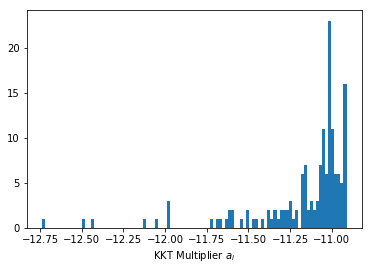

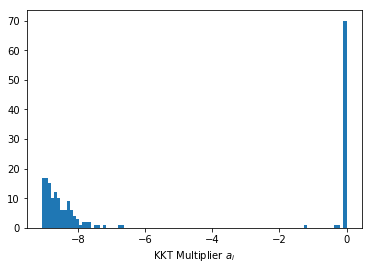

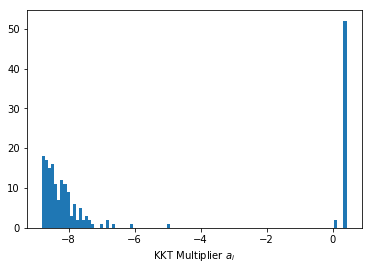

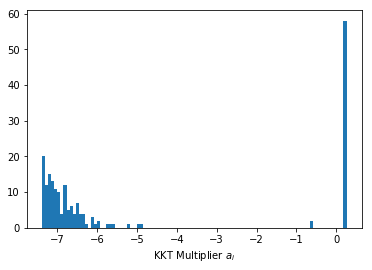

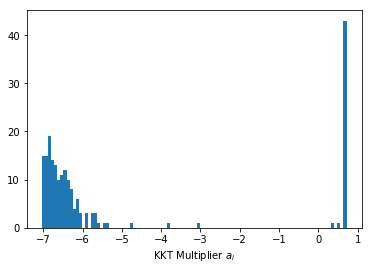

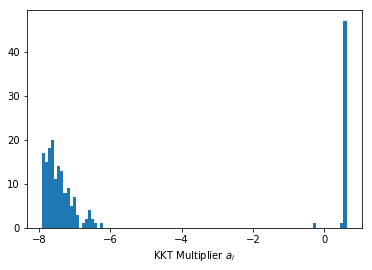

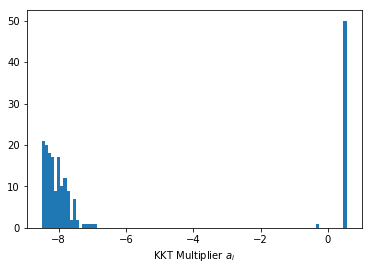

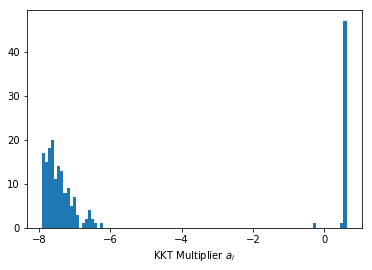

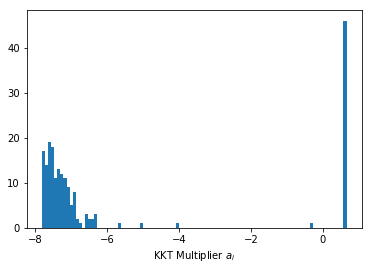

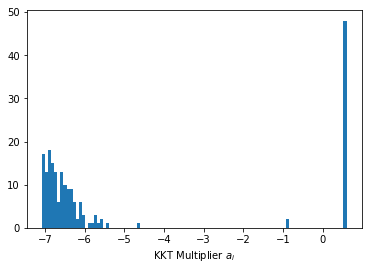

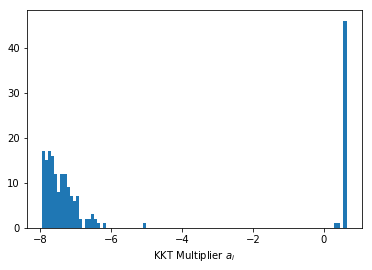

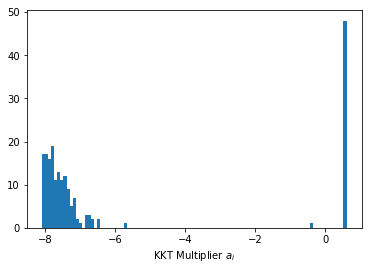

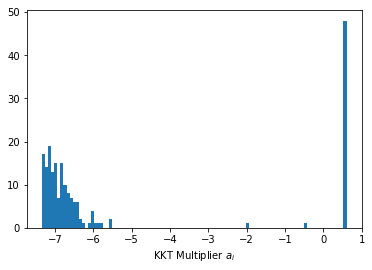

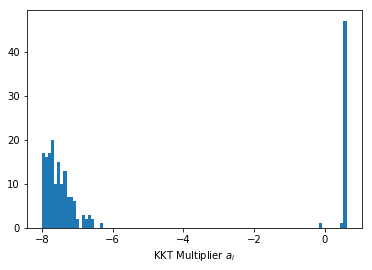

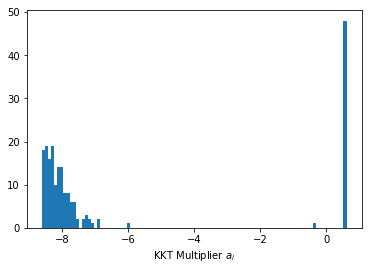

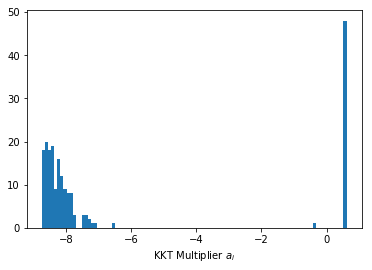

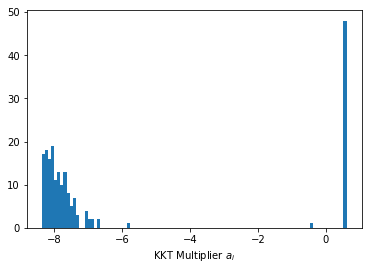

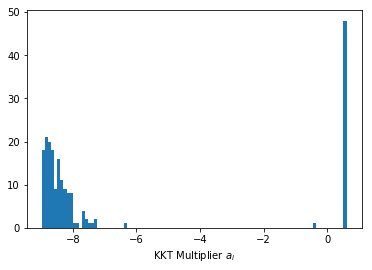

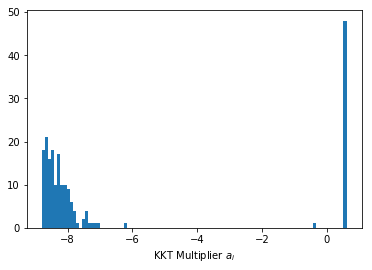

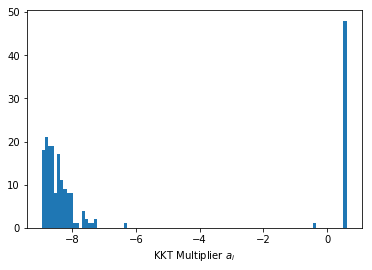

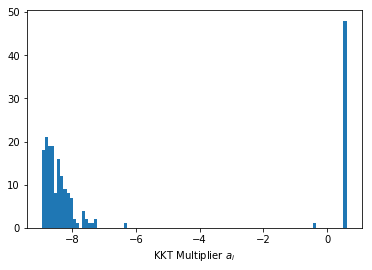

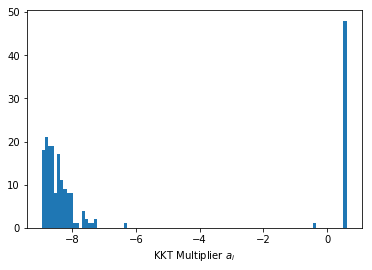

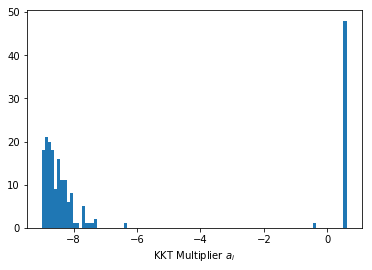

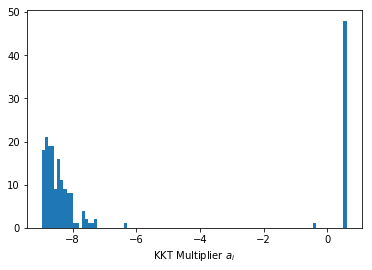

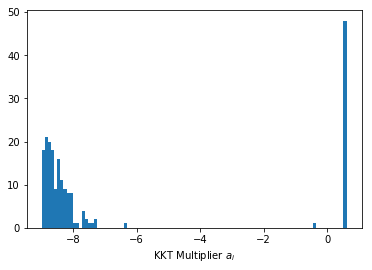

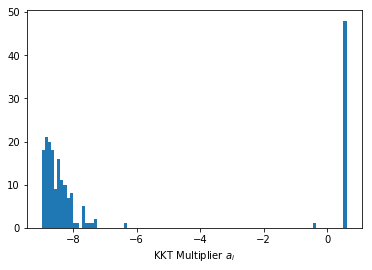

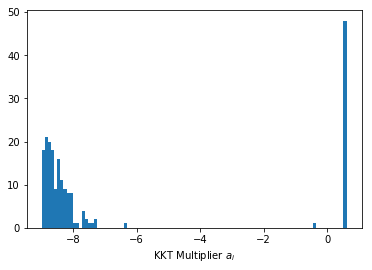

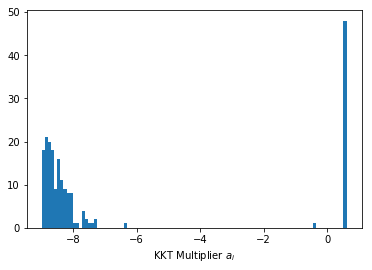

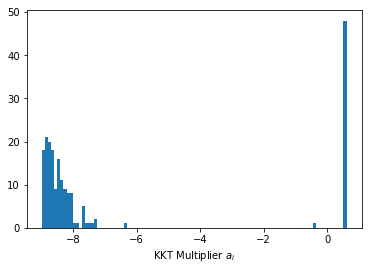

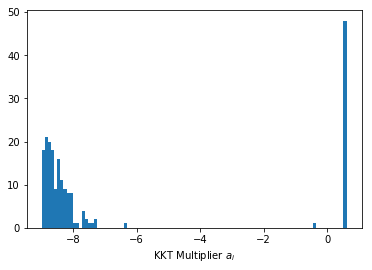

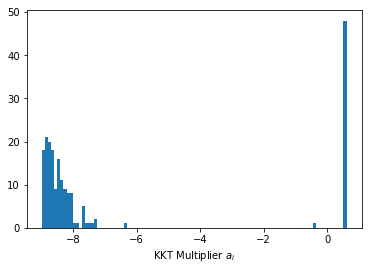

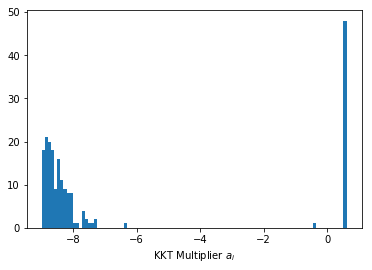

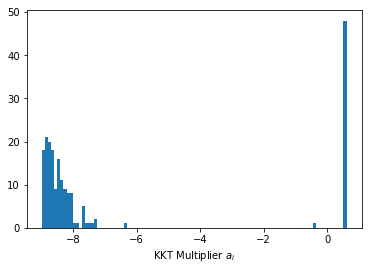

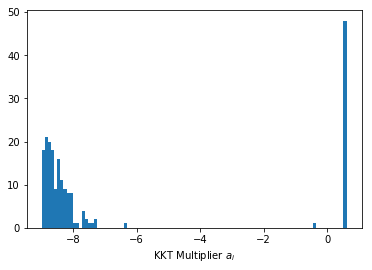

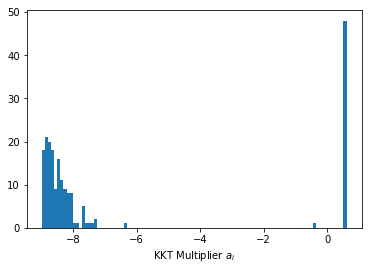

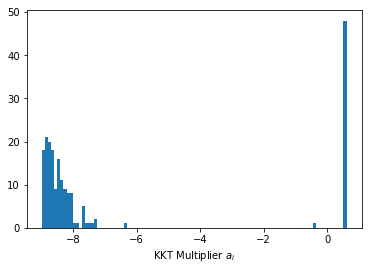

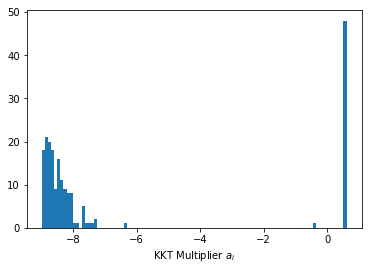

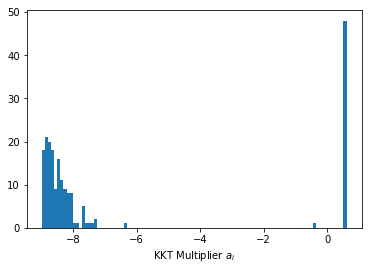

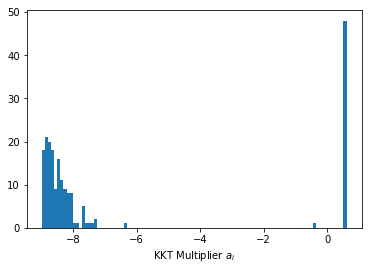

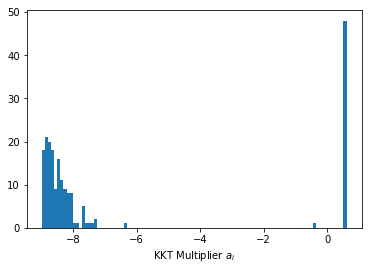

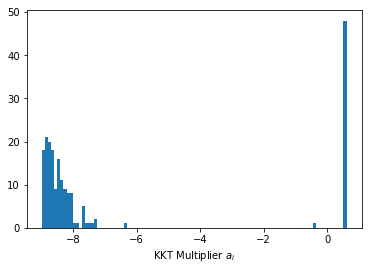

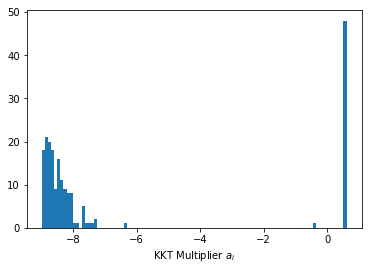

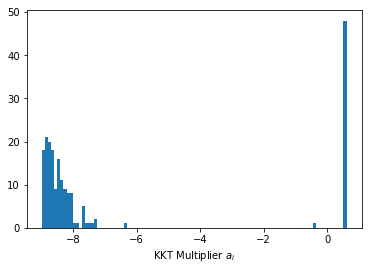

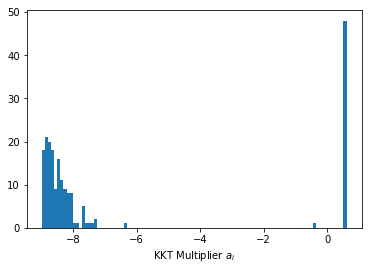

4.07094185430825


In [13]:

#The batch SVM loss as a function of slack value
def batch_loss(C):

	#Get the full batch solution to compare
	batch_data_x, batch_data_y,  batch_support_vects = batchSVM( xvals,yvals , C )

	bfull = b_value(batch_data_x,batch_data_y,batch_support_vects,C)

	batcherror = SVM_error(test_xvals,test_yvals, batch_data_x, batch_data_y, batch_support_vects,bfull)

	return batcherror


import scipy.optimize
#Tune over slack value
C = scipy.optimize.golden(batch_loss)

print(C)

In [ ]:

#Intial number of points used to compute steady state, can be user entered
N_start = 20

#the intial datapoints and labels
intial_xvals = xvals[0:N_start,:]
intial_yvals = yvals[0:N_start]

C = 15

#Get the intial set of active datapoints, active datapoint labels, support vector values and the Lagrange multiplier
intial_active_data_x, intial_active_data_y, intial_support_vects, index_val = EcoSVM_initialize(intial_xvals,intial_yvals,C)


#Run the EcoSVM algorithm on the dataset
active_data_x, active_data_y , support_vects , test_accuracy = Run_EcoSVM( xvals, yvals, intial_active_data_x, intial_active_data_y, intial_support_vects, index_val,  C  )


#Get the full batch solution to compare
batch_data_x, batch_data_y,  batch_support_vects = batchSVM( xvals,yvals , C )





#compute the b value
b = b_value(active_data_x,active_data_y,support_vects,C)
bfull = b_value(batch_data_x,batch_data_y,batch_support_vects,C)


#Compute performance errors
EcoSVMerror = SVM_error(xvals,yvals, active_data_x, active_data_y, support_vects,b)
print('EcoSVM train error:',EcoSVMerror)
EcoSVMerror = SVM_error(test_xvals,test_yvals, active_data_x, active_data_y, support_vects,b)
print('EcoSVM test error:',EcoSVMerror)

print('')

batcherror = SVM_error(xvals,yvals, batch_data_x, batch_data_y , batch_support_vects,bfull)
print('Batch SVM train error:', batcherror)
batcherror = SVM_error(test_xvals,test_yvals, batch_data_x, batch_data_y, batch_support_vects,bfull)
print('Batch SVM test error:', batcherror)




No active support vector found. Make sure that there are both +1 and -1 examples. Increase the number of intial points. Increase the slack.


IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:

#Function to make prediction plots
#See main text for detail
#only make plots in two dimensions
def make_plot():

	#Only make plots for two dimensional data
	if (dimension!=2):
		quit()


	#Make prediction plots
	k = 100
	batch_preds = np.zeros([k,k])
	EcoSVM_preds = np.zeros([k,k])
	x = 0
	y = 0
	dl = 1/k

	for i in range(k):

		x = 0

		for j in range(k):

			batch_preds[i,j] = np.sign( pred([x,y],batch_data_x,batch_data_y, batch_support_vects,bfull) )

			EcoSVM_preds[i,j] = np.sign( pred( [x,y] , active_data_x, active_data_y, support_vects,b ) )

			x = x + dl

		y = y + dl


	diffs = 0*batch_preds

	x = 0
	y = 0
	dl = 1/k

	for i in range(k):

		x = 0

		for j in range(k):

			if (batch_preds[i,j] == EcoSVM_preds[i,j]):

				if (EcoSVM_preds[i,j]==1):

					diffs[i,j] = -1

				if (EcoSVM_preds[i,j]==-1):

					diffs[i,j] = 1



			if (batch_preds[i,j]!=EcoSVM_preds[i,j]):

				diffs[i,j] = 3

			x = x + dl

		y = y + dl



	#plot first 100 train datapoints
	for i in range(100):

		if (yvals[i]==1):
			plt.plot(xvals[i,0],xvals[i,1],'.',c='g',marker='P',markersize=8,markeredgecolor='black')

		if (yvals[i]==-1):
			plt.plot(xvals[i,0],xvals[i,1],'.',c='r',marker='o',markersize=8,markeredgecolor='black')



	#also plot all active support vectors in larger markers
	for i in range(len(support_vects)):

		if ( (support_vects[i] - C)**2 > thresh  ):

			if (active_data_y[i]==1):

				plt.plot(active_data_x[i,0],active_data_x[i,1],'.',c='g',marker='P',markersize=22,markeredgecolor='black')

			if (active_data_y[i]==-1):

				plt.plot(active_data_x[i,0], active_data_x[i,1],'.',c='r',marker='o',markersize=22,markeredgecolor='black')


		#if (  (support_vects[i] - C )**2 < thresh ):

		#	if (active_data_y[i]==1):

		#		plt.plot(active_data_x[i,0],active_data_x[i,1],'.',c='g',marker='P',markersize=22,markeredgecolor='black')

		#	if (active_data_y[i]==-1):

		#		plt.plot(active_data_x[i,0], active_data_x[i,1],'.',c='r',marker='o',markersize=22,markeredgecolor='black')





	fontsize = 20
	plt.ylim(0,1)
	plt.xlim(0,1)
	plt.grid()
	plt.tick_params(labelsize=fontsize)
	plt.xlabel("$X_{1}$",size=fontsize+2)
	plt.ylabel("$X_{2}$",size = fontsize+2)


	from pylab import rcParams
	rcParams['figure.figsize'] = 500, 500

	
	gspace = np.linspace(0,1,100)
	yspace = 0.5 + nonlinearity*np.sin(2*np.pi*gspace)
	plt.plot(yspace,gspace,linestyle='--',linewidth=5,color='k')


	plt.imshow(diffs,origin='lower',extent=(0,1,0,1),cmap='cool')
	plt.tight_layout()
	plt.show()
    
	return diffs



diffs = make_plot()
